## Transaction Data Visualisation

In [1]:
# Pyspark libraries
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import lit, when
from pyspark.sql.functions import *
from pyspark.sql.functions import year
from pyspark.sql.functions import col, concat_ws
from pyspark.sql.functions import min, max

# Visualisation libraries
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL Project")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/04 20:58:02 WARN Utils: Your hostname, Bhavleens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.7 instead (on interface en0)
22/10/04 20:58:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/04 20:58:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/04 20:58:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load Dataset

In [3]:
dataset = spark.read.parquet("./../data/curated/part-00013-47f00a8c-554d-4703-b168-5eb79335c6d7-c000.snappy.parquet")

## Outliers

In [4]:
category = dataset.select('category').distinct()
for cat in category.collect():
    subset = dataset.filter(F.col("category") == cat[0])
    if (cat == 'retail_and_wholesale_trade'):
        subcategory = subset.select('subcategory').distinct()
        for subcat in subcategory.collect():
            sub = subset.filter(F.col("subcategory") == subcat[0])
            q3, q1 = sub.approxQuantile('dollar_value', [0.75, 0.25], 0) 
            iqr = q3 - q1
            min = q1 - 1.5*iqr
            max = q3 + 1.5*iqr

            if ('isOutlier' in dataset.columns):
                dataset = dataset.withColumn('isOutlier', 
                            when((dataset.subcategory == subcat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                            .when((dataset.subcategory == subcat[0]), lit('True'))
                            .otherwise(dataset.isOutlier))
            else:
                dataset = dataset.withColumn('isOutlier', 
                            when((dataset.subcategory == subcat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                            .when((dataset.subcategory == subcat[0]), lit('True')))
    else:
        q3, q1 = subset.approxQuantile('dollar_value', [0.75, 0.25], 0) 
        iqr = q3 - q1
        min = q1 - 1.5*iqr
        max = q3 + 1.5*iqr

        if ('isOutlier' in dataset.columns):
            dataset = dataset.withColumn('isOutlier', 
                        when((dataset.category == cat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                        .when((dataset.category == cat[0]), lit('True'))
                        .otherwise(dataset.isOutlier))
        else:
            dataset = dataset.withColumn('isOutlier', 
                        when((dataset.category == cat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                        .when((dataset.category == cat[0]), lit('True')))

### Keep relevant columns and feature engineer <br>

This will reduce run time by reducing the amount of data that functions will have to iterate through.

In [7]:
columns_to_keep = ["dollar_value", "order_datetime", "state", "postcode", "gender", "category", "subcategory", "estimated_region_population_2021_sum", "mean_earnings_2018-19_avg", "isOutlier"]
dataset = dataset.select(*columns_to_keep)
dataset.limit(3)

dollar_value,order_datetime,state,postcode,gender,category,subcategory,estimated_region_population_2021_sum,mean_earnings_2018-19_avg,isOutlier
366.23,2021-11-17,WA,6935,Female,retail_and_wholes...,others_retailing,10636,62144.0,True
587.4,2021-09-24,WA,6935,Female,retail_and_wholes...,department_stores,10636,62144.0,True
196.41,2022-05-22,WA,6935,Female,info_media_and_te...,null,10636,62144.0,False


Make new column such that the "category" and the "subcategory" column are combined. We can then implement Stratified Random Sampling (SRS) for plotting purposes, as the goal of SRS is to take samples from each subgroup based on the ratio of the sub-groups size to the total data-population. This insures that the presence of each sub-group is present when plotting.

In [8]:
concat_columns = ["category", "subcategory"]
dataset = dataset.withColumn("category_and_subcategory", concat_ws("-", *[F.col(x) for x in concat_columns]))

In [9]:
# Count of dataset without any outlier removal:
dataset.count()

13614156

## Continuation with Outliers

In [6]:
dataset_wo_outliers = dataset.filter(F.col("isOutlier") == 'False')

In [7]:
# Population Outlier Detection
population_q3, population_q1 = dataset_wo_outliers.approxQuantile('estimated_region_population_2021_sum', [0.75, 0.25], 0) 
population_iqr = population_q3 - population_q1
population_min = population_q1 - 1.5*population_iqr
population_max = population_q3 + 1.5*population_iqr

# Income Outlier Detection
income_q3, income_q1 = dataset_wo_outliers.approxQuantile('mean_earnings_2018-19_avg', [0.75, 0.25], 0) 
income_iqr = income_q3 - income_q1
income_min = income_q1 - 1.5*income_iqr
income_max = income_q3 + 1.5*income_iqr


final_dataset = dataset_wo_outliers.filter(((F.col("estimated_region_population_2021_sum") >= population_min) & 
                                            (F.col("estimated_region_population_2021_sum") <= population_max)) | 
                                            ((F.col("mean_earnings_2018-19_avg") >= income_min) & 
                                            (F.col("mean_earnings_2018-19_avg") <= income_max)))
final_dataset = final_dataset.withColumn('order_datetime', to_timestamp('order_datetime'))

### Proportinate Stratified Sampling function: <br>

<b>Input</b>: file with a list of attributes in the above field. <br>

<b>Output</b>: a proportionate stratified sample (w/o replacement) in the form of a pandas data frame, a pyspark data frame and the aggregate of the number of times "category_and_subcateogry" occur in the sample
(to see the spread).

### Notes: <br>

- weight ∈ (0, ∞)

- After several attempts to maximise the sample size without giving an ERROR, a "weight" of 9 was chosen due to computational resource allocation limits.<br>
Lower weight --> bigger sample.<br>
Higher weight --> smaller sample.

In [12]:
def get_stratified_data_sample(file_name):

    ZERO = 0
    HUNDRED = 100

    weight = 9
    no_decimals = 4
    no_rows = file_name.count()

    # Create a dictionary where the KEYS represent the different category and subcateogries, and the VALUES represent the number of time they occur:
    d = dict([(x['category_and_subcategory'], x['count']) for x in file_name.groupBy("category_and_subcategory").count().collect()])

    # Divide value with number of rows to get the correct proportion and multiply the denominator with the "weight" to adjust the sample size:
    d.update((key, value/(no_rows*weight)) for key, value in d.items())

    # Sample
    sample_data = file_name.sampleBy("category_and_subcategory", fractions = d, seed = ZERO)
    no_sample_rows = sample_data.count()

    # Convert sample to a pandas data frame:
    sample_data_pdf = sample_data.toPandas()

    # Create aggregate:
    category_summary = sample_data \
                        .groupBy("category_and_subcategory") \
                        .agg(
                            F.count("category_and_subcategory").alias("COUNT"),
                            F.round((((F.count("category_and_subcategory")/no_sample_rows))*HUNDRED), no_decimals).alias("%"),
                            F.round(((F.count("category_and_subcategory")/no_sample_rows)), no_decimals).alias("Decimal")
                        )
    
    return sample_data_pdf, sample_data, category_summary

## Distributions of Variables with and without Outliers

Aggregation of full dataset before any outlier removal:

In [38]:
no_sample_rows = dataset.count()

category_summary = dataset \
                    .groupBy("category_and_subcategory") \
                    .agg(
                        F.count("category_and_subcategory").alias("COUNT"),
                        F.round((((F.count("category_and_subcategory")/no_sample_rows))*100), 4).alias("%"),
                        F.round(((F.count("category_and_subcategory")/no_sample_rows)), 4).alias("Decimal")
                    )

category_summary.show(truncate = False)

+--------------------------------------------------------------------------+-------+-------+-------+
|category_and_subcategory                                                  |COUNT  |%      |Decimal|
+--------------------------------------------------------------------------+-------+-------+-------+
|retail_and_wholesale_trade-department_stores                              |6199881|45.54  |0.4554 |
|rental_hiring_and_real_estate                                             |36695  |0.2695 |0.0027 |
|retail_and_wholesale_trade-food_retailing                                 |347322 |2.5512 |0.0255 |
|arts_and_recreation                                                       |21218  |0.1559 |0.0016 |
|others                                                                    |245753 |1.8051 |0.0181 |
|retail_and_wholesale_trade-clothing_footwear__personal_accessory_retailing|1036315|7.612  |0.0761 |
|info_media_and_telecommunications                                         |1904458|13.9888

Sample of dataset before ANY outlier removal:

In [13]:
dataset_df, dataset_sdf, dataset_aggr = get_stratified_data_sample(dataset)

In [16]:
len(dataset_df)

419221

In [18]:
dataset_aggr.show(truncate = False)

+--------------------------------------------------------------------------+------+-------+-------+
|category_and_subcategory                                                  |COUNT |%      |Decimal|
+--------------------------------------------------------------------------+------+-------+-------+
|retail_and_wholesale_trade-department_stores                              |314154|74.9376|0.7494 |
|rental_hiring_and_real_estate                                             |13    |0.0031 |0.0    |
|retail_and_wholesale_trade-food_retailing                                 |988   |0.2357 |0.0024 |
|others                                                                    |490   |0.1169 |0.0012 |
|retail_and_wholesale_trade-clothing_footwear__personal_accessory_retailing|8691  |2.0731 |0.0207 |
|info_media_and_telecommunications                                         |29473 |7.0304 |0.0703 |
|retail_and_wholesale_trade-others_retailing                               |14229 |3.3942 |0.0339 |


Sample of dataset AFTER outlier removal (excluding outliers from external dataset):

In [14]:
dataset_wo_outliers_df, dataset_wo_outliers_sdf, dataset_wo_outliers_aggr = get_stratified_data_sample(dataset_wo_outliers)

In [19]:
len(dataset_wo_outliers_df)

378131

In [20]:
dataset_wo_outliers_aggr.show(truncate = False)

+--------------------------------------------------------------------------+------+-------+-------+
|category_and_subcategory                                                  |COUNT |%      |Decimal|
+--------------------------------------------------------------------------+------+-------+-------+
|retail_and_wholesale_trade-department_stores                              |282632|74.7445|0.7474 |
|rental_hiring_and_real_estate                                             |11    |0.0029 |0.0    |
|retail_and_wholesale_trade-food_retailing                                 |516   |0.1365 |0.0014 |
|arts_and_recreation                                                       |4     |0.0011 |0.0    |
|others                                                                    |529   |0.1399 |0.0014 |
|retail_and_wholesale_trade-clothing_footwear__personal_accessory_retailing|9402  |2.4864 |0.0249 |
|info_media_and_telecommunications                                         |27846 |7.3641 |0.0736 |


Sample of dataset AFTER ALL outlier removal:

In [15]:
final_dataset_df, final_dataset_sdf, final_dataset_aggr = get_stratified_data_sample(final_dataset)

In [21]:
len(final_dataset_df)

372261

In [23]:
final_dataset_aggr.show(truncate = False)

+--------------------------------------------------------------------------+------+-------+-------+
|category_and_subcategory                                                  |COUNT |%      |Decimal|
+--------------------------------------------------------------------------+------+-------+-------+
|retail_and_wholesale_trade-department_stores                              |278331|74.7677|0.7477 |
|rental_hiring_and_real_estate                                             |4     |0.0011 |0.0    |
|retail_and_wholesale_trade-food_retailing                                 |478   |0.1284 |0.0013 |
|others                                                                    |526   |0.1413 |0.0014 |
|retail_and_wholesale_trade-clothing_footwear__personal_accessory_retailing|9291  |2.4958 |0.025  |
|info_media_and_telecommunications                                         |27257 |7.322  |0.0732 |
|retail_and_wholesale_trade-others_retailing                               |9806  |2.6342 |0.0263 |


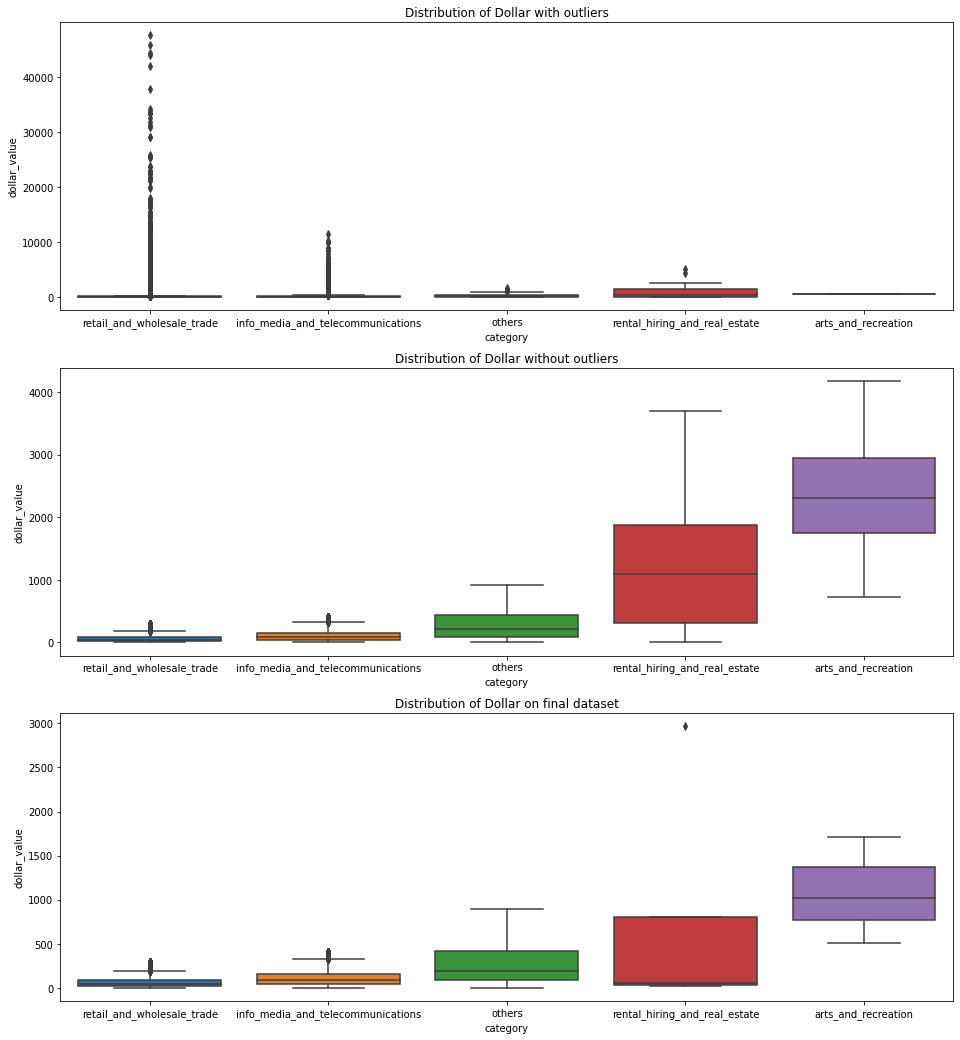

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

boxplot = sns.boxplot(ax= axes[0], data=dataset_df, x="category", y="dollar_value").set(title = 'Distribution of Dollar with outliers')
boxplot2 = sns.boxplot(ax= axes[1], data=dataset_wo_outliers_df, x="category", y="dollar_value").set(title = 'Distribution of Dollar without outliers')
boxplot3 = sns.boxplot(ax= axes[2], data=final_dataset_df, x="category", y="dollar_value").set(title = 'Distribution of Dollar on final dataset')

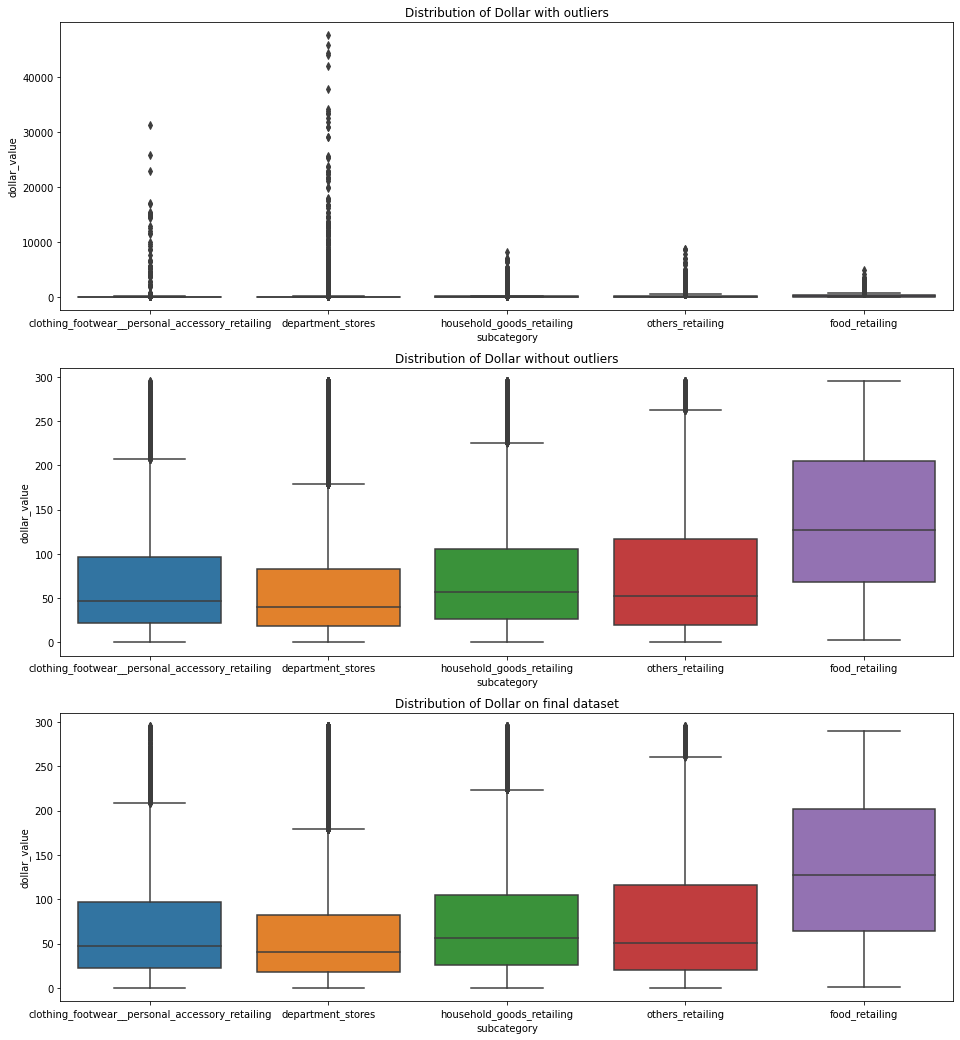

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

boxplot = sns.boxplot(ax= axes[0], data=dataset_df, x="subcategory", y="dollar_value").set(title = 'Distribution of Dollar with outliers')
boxplot2 = sns.boxplot(ax= axes[1], data=dataset_wo_outliers_df, x="subcategory", y="dollar_value").set(title = 'Distribution of Dollar without outliers')
boxplot3 = sns.boxplot(ax= axes[2], data=final_dataset_df, x="subcategory", y="dollar_value").set(title = 'Distribution of Dollar on final dataset')

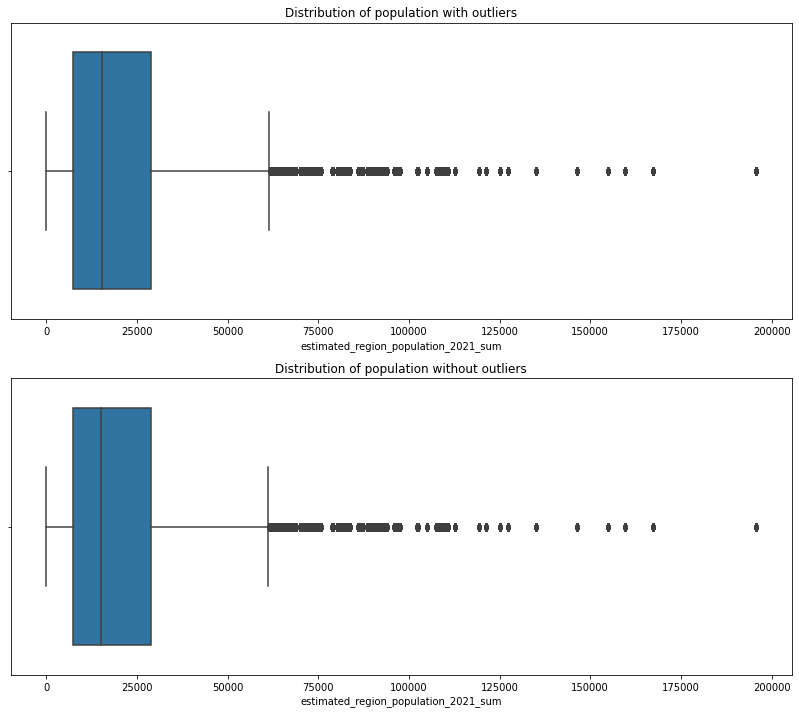

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(14,12))

boxplot = sns.boxplot(ax= axes[0], data=dataset_wo_outliers_df, x="estimated_region_population_2021_sum").set(title = 'Distribution of population with outliers')
boxplot2 = sns.boxplot(ax= axes[1], data=final_dataset_df, x="estimated_region_population_2021_sum").set(title = 'Distribution of population without outliers')

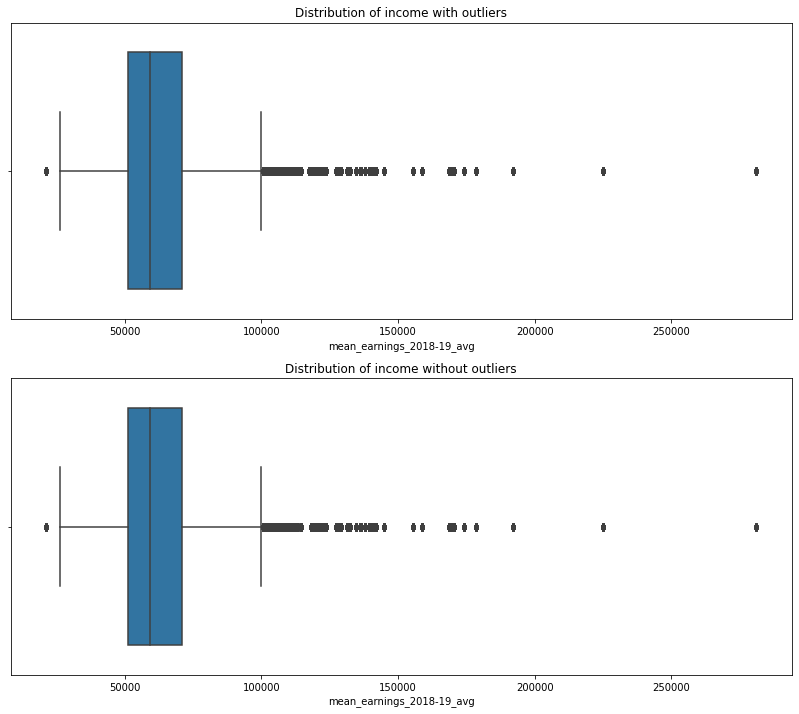

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(14,12))

boxplot = sns.boxplot(ax= axes[0], data=dataset_wo_outliers_df, x="mean_earnings_2018-19_avg").set(title = 'Distribution of income with outliers')
boxplot2 = sns.boxplot(ax= axes[1], data=final_dataset_df, x="mean_earnings_2018-19_avg").set(title = 'Distribution of income without outliers')

## Alternative Method for Distribution

In [17]:
category_describe = dataset.groupBy('category').agg(avg('dollar_value').alias('mean'),stddev('dollar_value').alias('stddev'),
                                                    min('dollar_value').alias('min'), max('dollar_value').alias('max'))\
                                                .toPandas().set_index('category').T
category_describe_wo_outlier = dataset_wo_outliers.groupBy('category').agg(avg('dollar_value').alias('mean'),stddev('dollar_value').alias('stddev'),
                                                    min('dollar_value').alias('min'), max('dollar_value').alias('max'))\
                                                .toPandas().set_index('category').T
category_describe_final = final_dataset.groupBy('category').agg(avg('dollar_value').alias('mean'),stddev('dollar_value').alias('stddev'),
                                                    min('dollar_value').alias('min'), max('dollar_value').alias('max'))\
                                                .toPandas().set_index('category').T

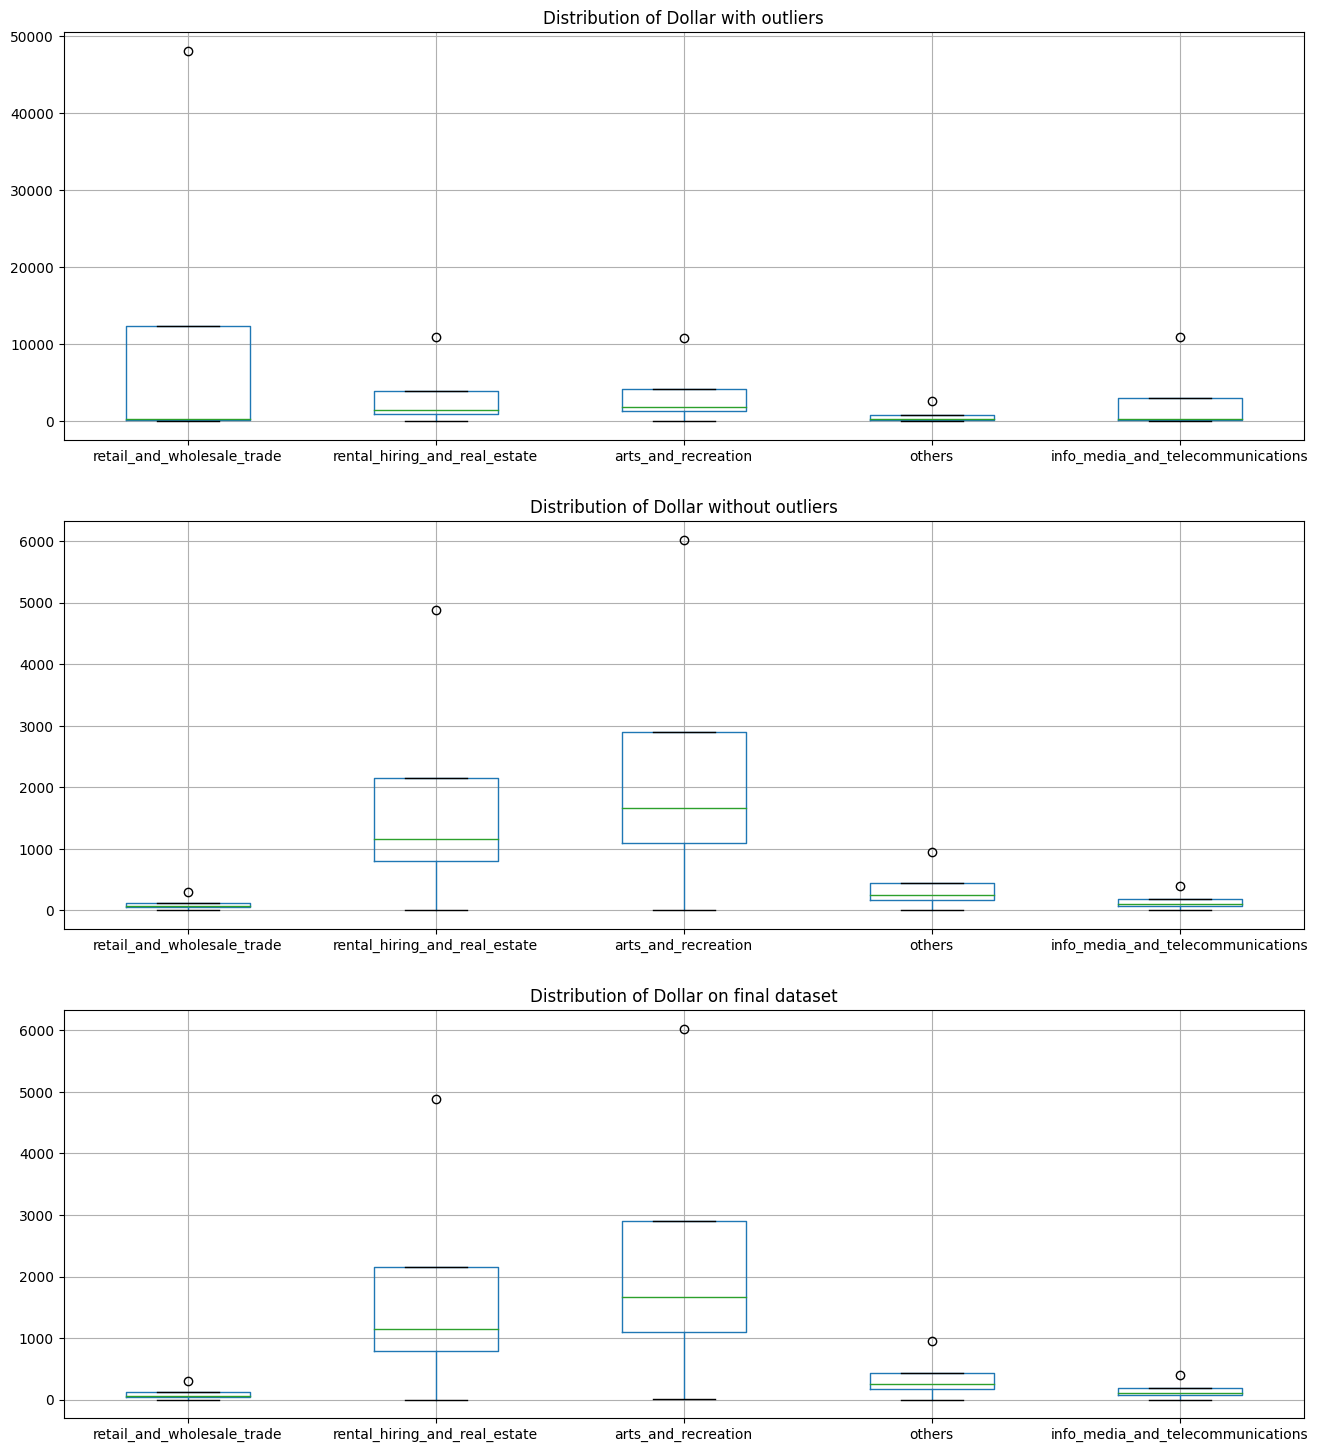

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

boxplot = category_describe.boxplot(ax= axes[0]).set(title = 'Distribution of Dollar with outliers')
boxplot2 = category_describe_wo_outlier.boxplot(ax= axes[1]).set(title = 'Distribution of Dollar without outliers')
boxplot3 = category_describe_final.boxplot(ax= axes[2]).set(title = 'Distribution of Dollar on final dataset')

In [49]:
subcategory_describe = dataset.groupBy('subcategory').agg(avg('dollar_value').alias('mean'),stddev('dollar_value').alias('stddev'),
                                                    min('dollar_value').alias('min'), max('dollar_value').alias('max'))\
                                                .toPandas().set_index('subcategory').T.drop(columns= [None])
subcategory_describe_wo_outlier = dataset_wo_outliers.groupBy('subcategory').agg(avg('dollar_value').alias('mean'),stddev('dollar_value').alias('stddev'),
                                                    min('dollar_value').alias('min'), max('dollar_value').alias('max'))\
                                                .toPandas().set_index('subcategory').T.drop(columns= [None])
subcategory_describe_final = final_dataset.groupBy('subcategory').agg(avg('dollar_value').alias('mean'),stddev('dollar_value').alias('stddev'),
                                                    min('dollar_value').alias('min'), max('dollar_value').alias('max'))\
                                                .toPandas().set_index('subcategory').T.drop(columns= [None])

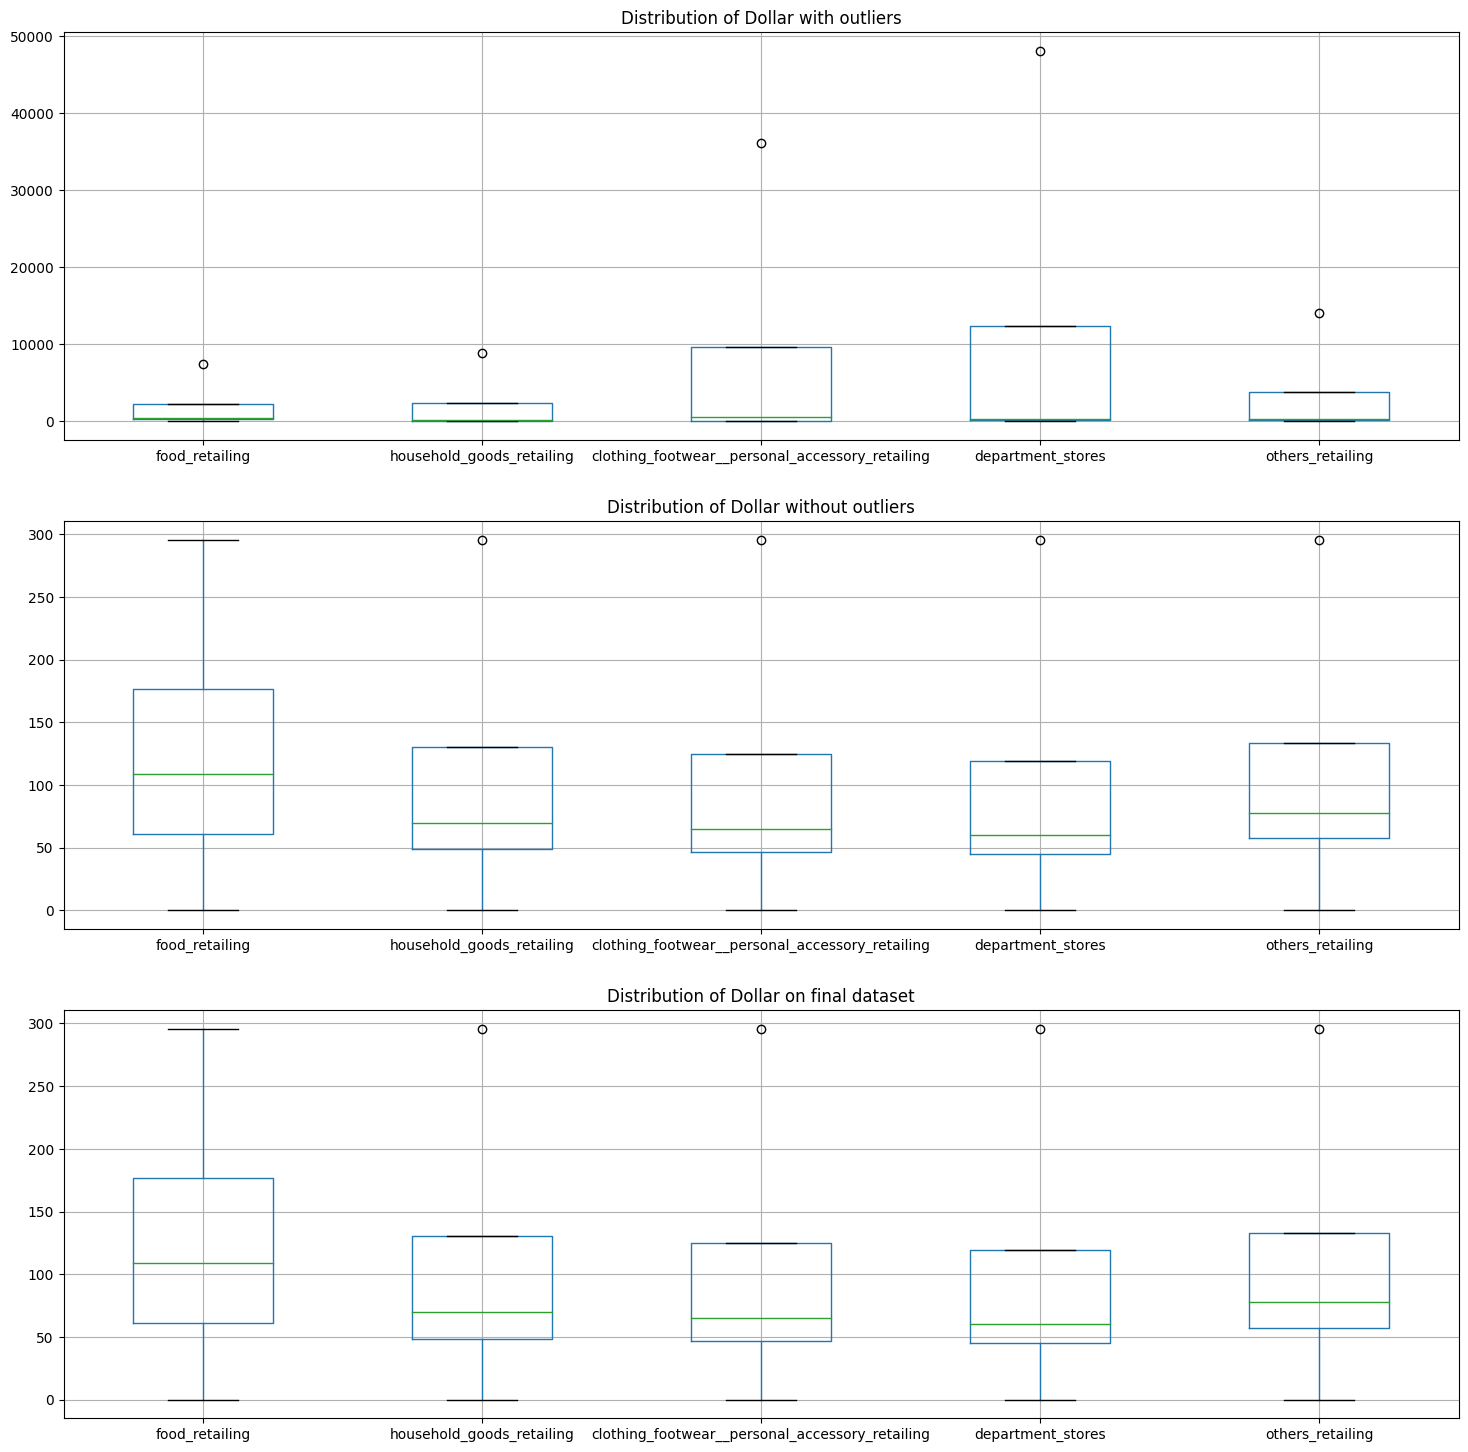

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(18,18))

boxplot = subcategory_describe.boxplot(ax= axes[0]).set(title = 'Distribution of Dollar with outliers')
boxplot2 = subcategory_describe_wo_outlier.boxplot(ax= axes[1]).set(title = 'Distribution of Dollar without outliers')
boxplot3 = subcategory_describe_final.boxplot(ax= axes[2]).set(title = 'Distribution of Dollar on final dataset')

In [22]:
category_income_wo_outlier = dataset_wo_outliers.groupBy('category').agg(avg('mean_earnings_2018-19_avg').alias('mean'),stddev('mean_earnings_2018-19_avg').alias('stddev'),
                                                    min('mean_earnings_2018-19_avg').alias('min'), max('mean_earnings_2018-19_avg').alias('max'))\
                                                .toPandas().set_index('category').T
category_income_final = final_dataset.groupBy('category').agg(avg('mean_earnings_2018-19_avg').alias('mean'),stddev('mean_earnings_2018-19_avg').alias('stddev'),
                                                    min('mean_earnings_2018-19_avg').alias('min'), max('mean_earnings_2018-19_avg').alias('max'))\
                                                .toPandas().set_index('category').T

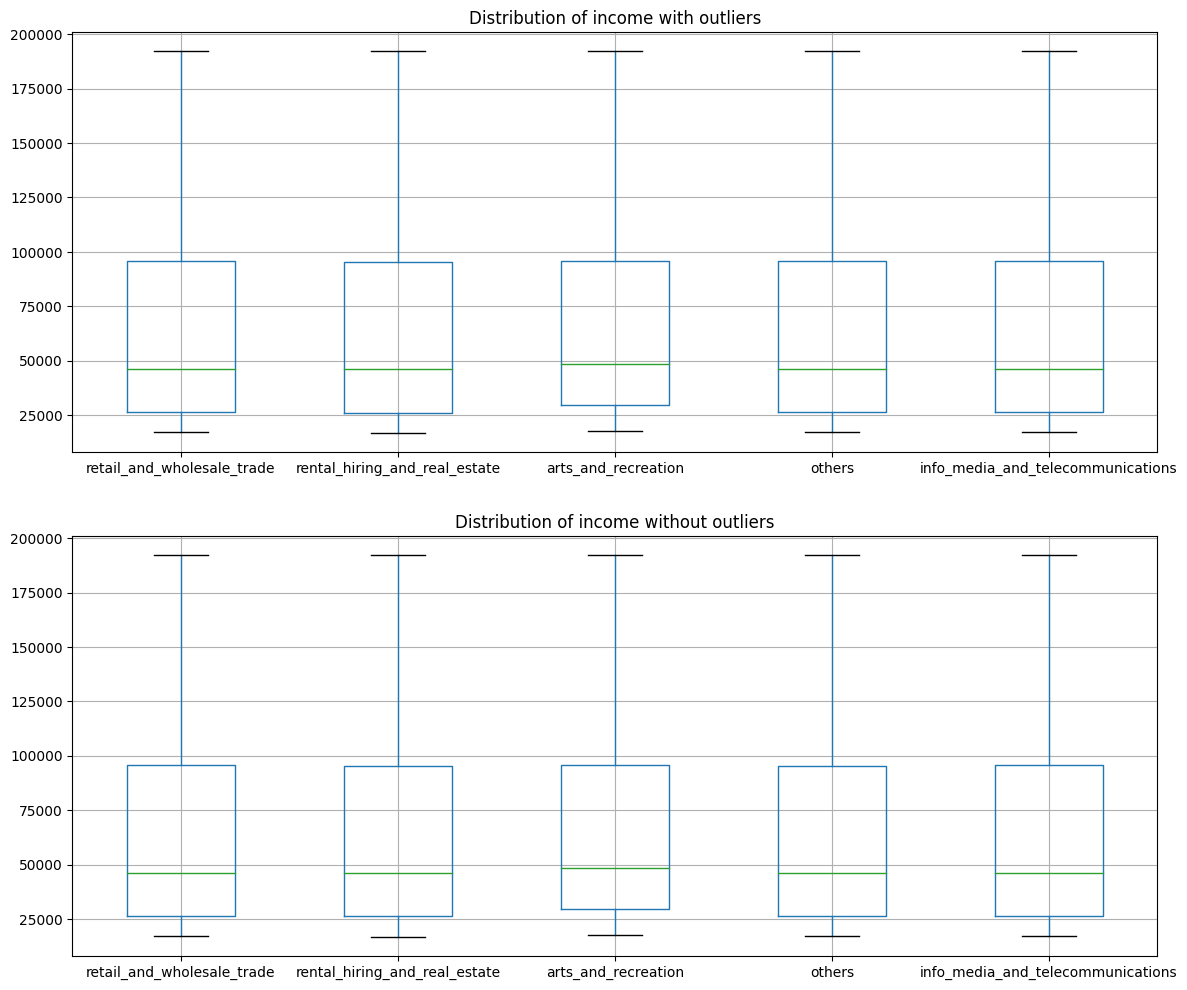

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(14,12))

boxplot = category_income_wo_outlier.boxplot(ax= axes[0]).set(title = 'Distribution of income with outliers')
boxplot2 = category_income_final.boxplot(ax= axes[1]).set(title = 'Distribution of income without outliers')

In [47]:
subcategory_income_wo_outlier = dataset_wo_outliers.groupBy('subcategory').agg(avg('mean_earnings_2018-19_avg').alias('mean'),stddev('mean_earnings_2018-19_avg').alias('stddev'),
                                                    min('mean_earnings_2018-19_avg').alias('min'), max('mean_earnings_2018-19_avg').alias('max'))\
                                                .toPandas().set_index('subcategory').T.drop(columns= [None])
subcategory_income_final = final_dataset.groupBy('subcategory').agg(avg('mean_earnings_2018-19_avg').alias('mean'),stddev('mean_earnings_2018-19_avg').alias('stddev'),
                                                    min('mean_earnings_2018-19_avg').alias('min'), max('mean_earnings_2018-19_avg').alias('max'))\
                                                .toPandas().set_index('subcategory').T.drop(columns= [None])

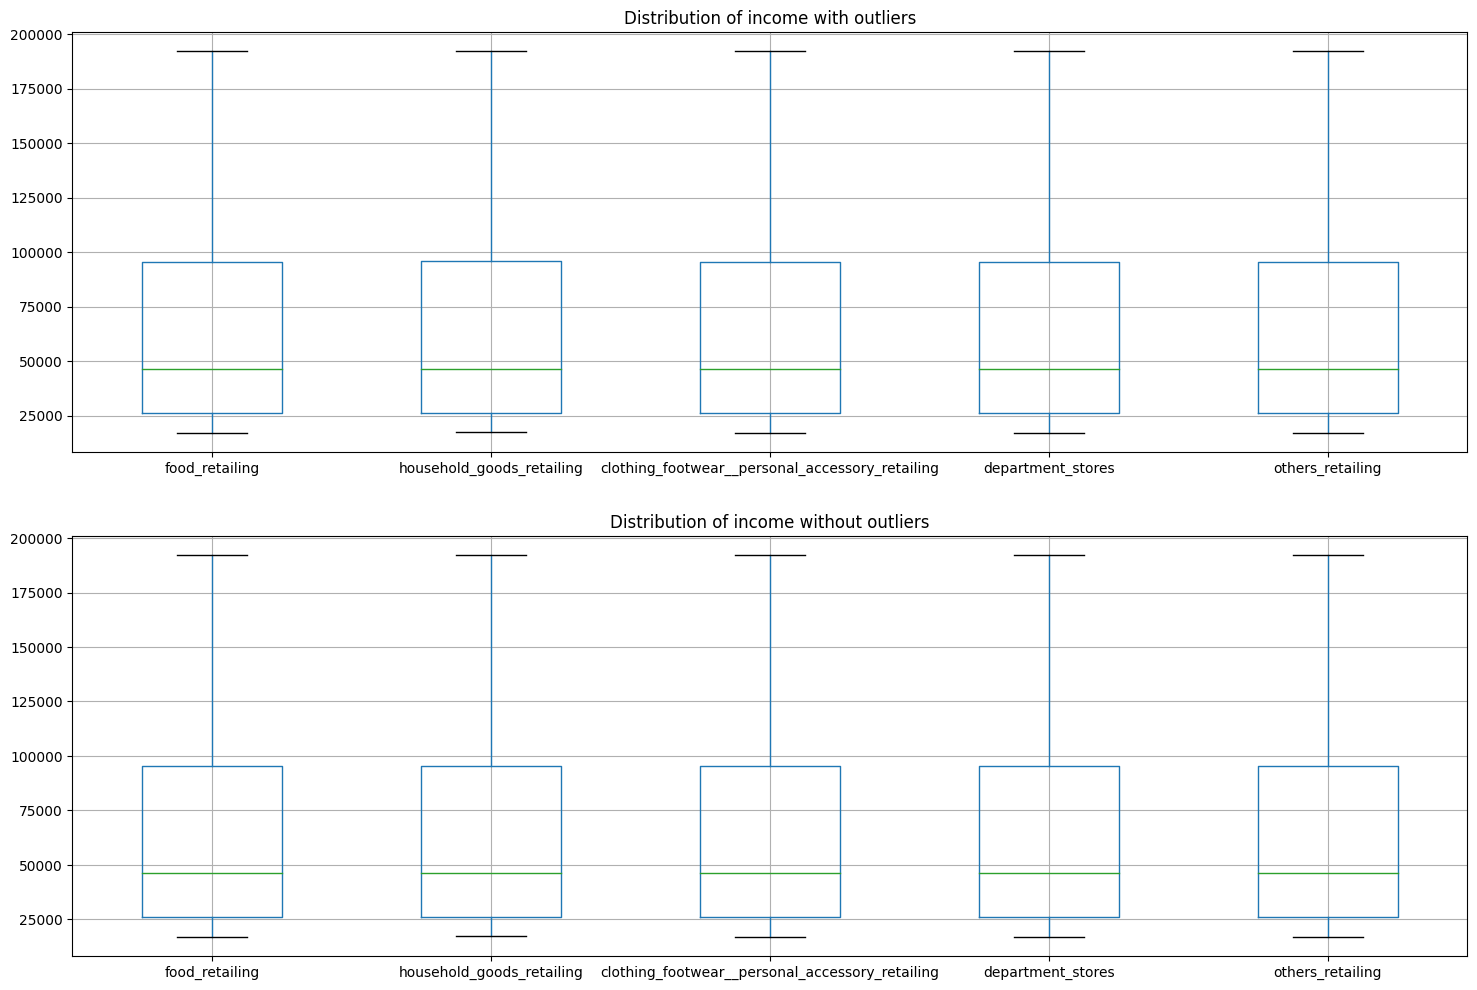

In [48]:
fig, axes = plt.subplots(2, 1, figsize=(18,12))

boxplot = subcategory_income_wo_outlier.boxplot(ax= axes[0]).set(title = 'Distribution of income with outliers')
boxplot2 = subcategory_income_final.boxplot(ax= axes[1]).set(title = 'Distribution of income without outliers')

In [26]:
category_population_wo_outlier = dataset_wo_outliers.groupBy('category').agg(avg('estimated_region_population_2021_sum').alias('mean'),
                                                    stddev('estimated_region_population_2021_sum').alias('stddev'),
                                                    min('estimated_region_population_2021_sum').alias('min'), 
                                                    max('estimated_region_population_2021_sum').alias('max'))\
                                                    .toPandas().set_index('category').T
category_population_final = final_dataset.groupBy('category').agg(avg('estimated_region_population_2021_sum').alias('mean'),
                                            stddev('estimated_region_population_2021_sum').alias('stddev'),
                                            min('estimated_region_population_2021_sum').alias('min'), 
                                            max('estimated_region_population_2021_sum').alias('max'))\
                                            .toPandas().set_index('category').T

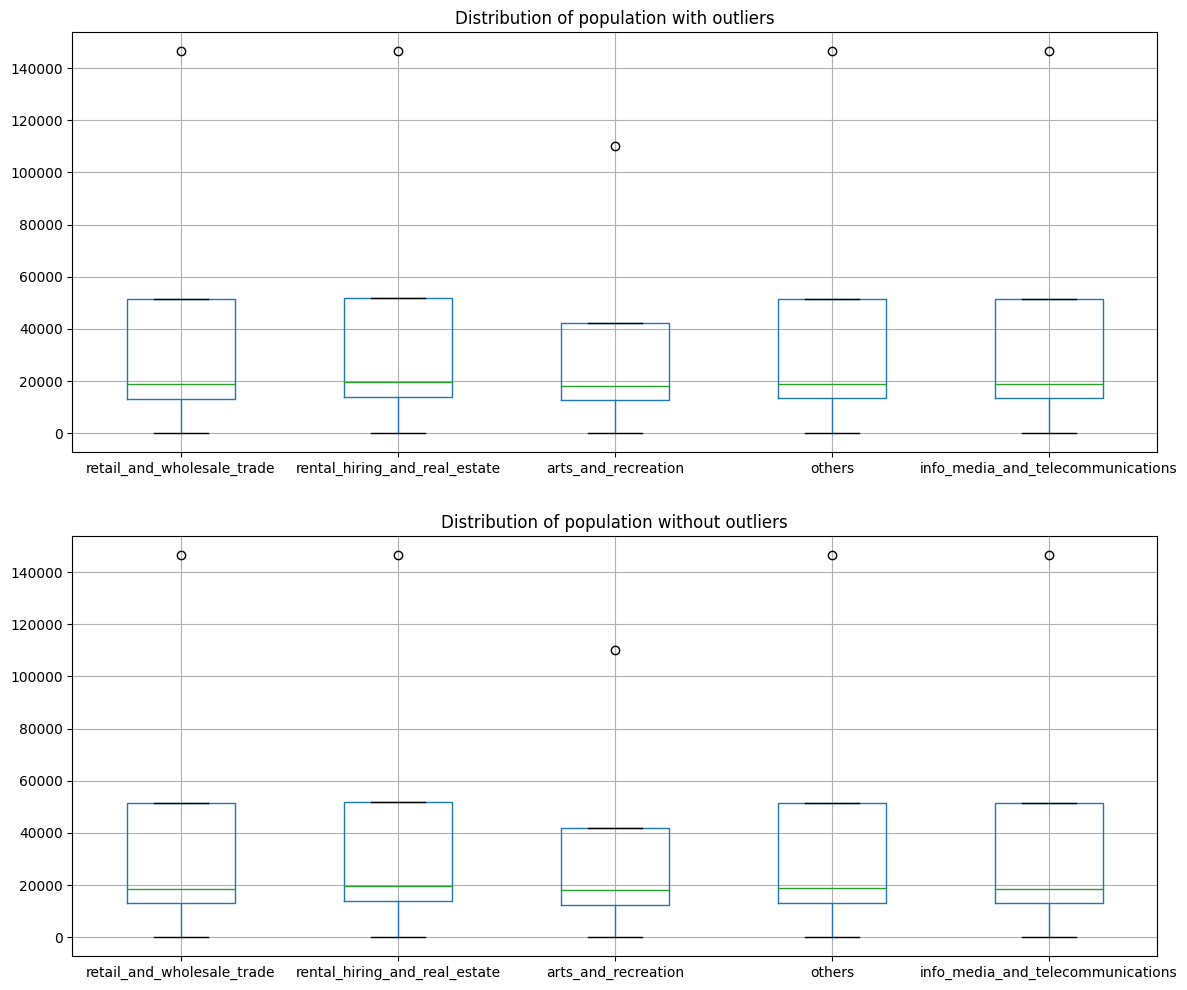

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(14,12))

boxplot = category_population_wo_outlier.boxplot(ax= axes[0]).set(title = 'Distribution of population with outliers')
boxplot2 = category_population_final.boxplot(ax= axes[1]).set(title = 'Distribution of population without outliers')

In [41]:
subcategory_population_wo_outlier = dataset_wo_outliers.groupBy('subcategory').agg(avg('estimated_region_population_2021_sum').alias('mean'),
                                                    stddev('estimated_region_population_2021_sum').alias('stddev'),
                                                    min('estimated_region_population_2021_sum').alias('min'), 
                                                    max('estimated_region_population_2021_sum').alias('max'))\
                                                    .toPandas().set_index('subcategory').T.drop(columns= [None])
subcategory_population_final = final_dataset.groupBy('subcategory').agg(avg('estimated_region_population_2021_sum').alias('mean'),
                                            stddev('estimated_region_population_2021_sum').alias('stddev'),
                                            min('estimated_region_population_2021_sum').alias('min'), 
                                            max('estimated_region_population_2021_sum').alias('max'))\
                                            .toPandas().set_index('subcategory').T.drop(columns= [None])

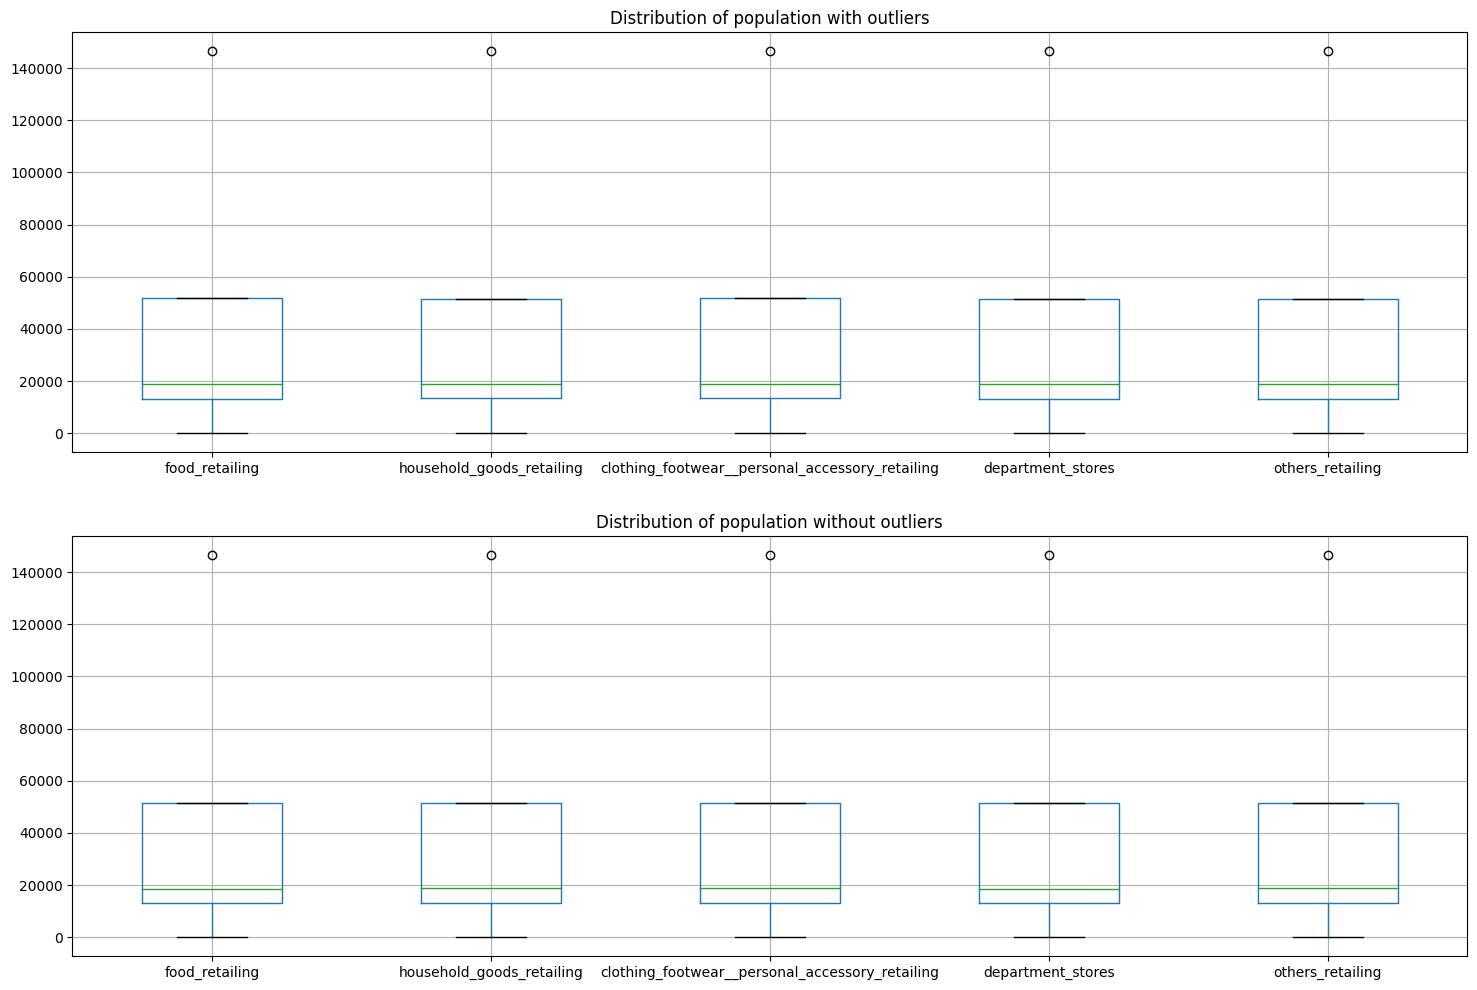

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(18,12))

boxplot = subcategory_population_wo_outlier.boxplot(ax= axes[0]).set(title = 'Distribution of population with outliers')
boxplot2 = subcategory_population_final.boxplot(ax= axes[1]).set(title = 'Distribution of population without outliers')

## Relationship between Features

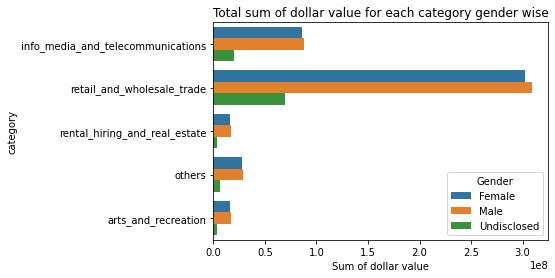

In [44]:
gender_category = final_dataset.groupBy('category', 'gender').sum('dollar_value')
sns.barplot(data= gender_category.toPandas(), x= 'sum(dollar_value)', y="category", hue="gender")
plt.title('Total sum of dollar value for each category gender wise')
plt.xlabel('Sum of dollar value')
plt.legend(loc='lower right', title='Gender')

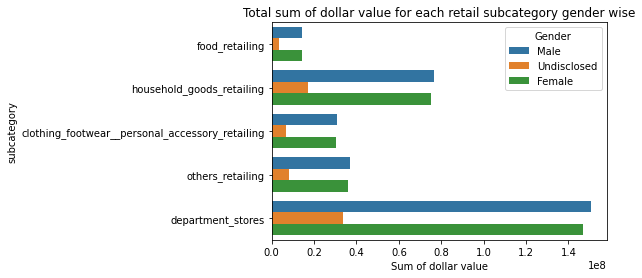

In [43]:
gender_subcategory = final_dataset.groupBy('subcategory', 'gender').sum('dollar_value')
sns.barplot(data= gender_subcategory.toPandas(), x= 'sum(dollar_value)', y="subcategory", hue="gender")
plt.title('Total sum of dollar value for each retail subcategory gender wise')
plt.xlabel('Sum of dollar value')
plt.legend(loc='upper right', title='Gender')

Text(0, 0.5, 'Sum of dollar value')

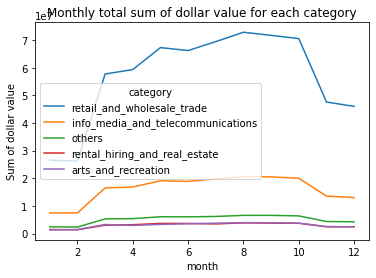

In [42]:
category_monthly = final_dataset.withColumn('month', month(final_dataset.order_datetime)).groupBy('category', 'month').sum('dollar_value')
sns.lineplot(data= category_monthly.toPandas(), x= 'month', y= 'sum(dollar_value)', hue= 'category')
plt.title('Monthly total sum of dollar value for each category')
plt.ylabel('Sum of dollar value')

Text(0, 0.5, 'Sum of dollar value')

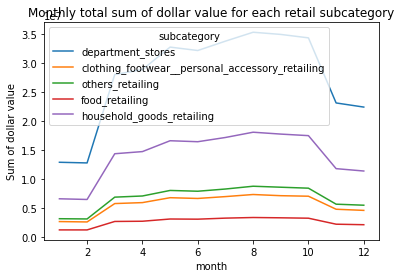

In [41]:
subcategory_monthly = final_dataset.withColumn('month', month(final_dataset.order_datetime)).groupBy('subcategory', 'month').sum('dollar_value')
subcategory_monthly = subcategory_monthly.na.drop()
sns.lineplot(data= subcategory_monthly.toPandas(), x= 'month', y= 'sum(dollar_value)', hue= 'subcategory')
plt.title('Monthly total sum of dollar value for each retail subcategory')
plt.ylabel('Sum of dollar value')

Text(0, 0.5, 'Sum of dollar value')

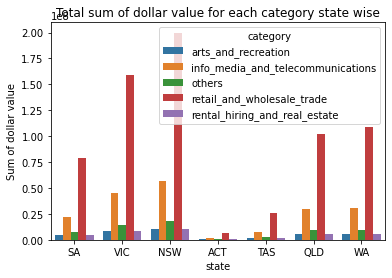

In [40]:
state_category = final_dataset.groupBy('category', 'state').sum('dollar_value')
sns.barplot(data= state_category.toPandas(), x= "state", y= "sum(dollar_value)", hue= "category")
plt.title('Total sum of dollar value for each category state wise')
plt.ylabel('Sum of dollar value')

Text(0, 0.5, 'Sum of dollar value')

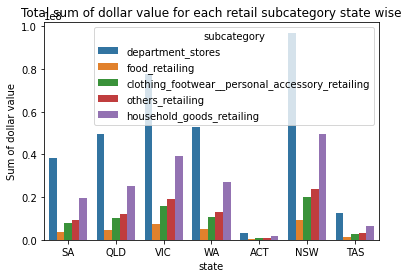

In [39]:
state_subcategory = final_dataset.groupBy('subcategory', 'state').sum('dollar_value')
sns.barplot(data= state_subcategory.toPandas(), x= "state", y= "sum(dollar_value)", hue= "subcategory")
plt.title('Total sum of dollar value for each retail subcategory state wise')
plt.ylabel('Sum of dollar value')